# Dimensionality Reduction

An unsupervised transformation that is somewhat more interesting is Principal Component Analysis (PCA).
It is a technique to reduce the dimensionality of the data, by creating a linear projection.
That is, we find new features to represent the data that are a linear combination of the old data (i.e. we rotate it). Thus, we can think of PCA as a projection of our data onto a *new* feature space.

The way PCA finds these new directions is by looking for the directions of maximum variance.
Usually only few components that explain most of the variance in the data are kept. Here, the premise is to reduce the size (dimensionality) of a dataset while capturing most of its information. There are many reason why dimensionality reduction can be useful: It can reduce the computational cost when running learning algorithms, decrease the storage space, and may help with the so-called "curse of dimensionality," which we will discuss in greater detail later.

To illustrate how a rotation might look like, we first show it on two-dimensional data and keep both principal components. Here is an illustraion:

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True).fit(iris.data)
X_pca = pca.transform(iris.data)

In [5]:
import pandas as pd
iris_df = (pd.DataFrame(iris.data, columns=iris.feature_names)
               .assign(species=iris.target_names[iris.target]))

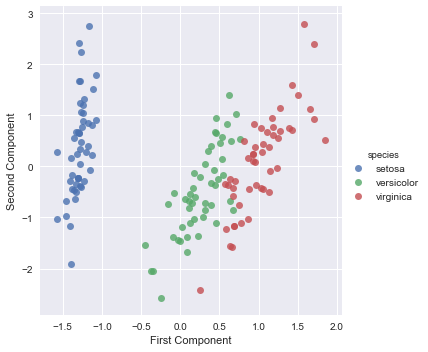

In [8]:
%matplotlib inline
import seaborn as sns

iris_df['First Component'] = X_pca[:, 0]
iris_df['Second Component'] = X_pca[:, 1]

sns.lmplot('First Component', 'Second Component', 
           data=iris_df, 
           fit_reg=False, 
           hue="species");